# Intro

Welcome to the interactive tracking notebook!\
This notebook goes through each step and allows you to tune parameters and view how it changes the results.

The notebook proceeds as follows:
1. **Import** libraries
2. Define **paths** to data
3. Run data through the **pipeline**. Each step of the pipeline is run by a single unique python class.
4. **Visualize** results
5. **Save** results

As you go through the notebook, take note of the small number of parameters that are mentioned as **'important parameters'** (consider searching for these in the notebook). We consider these to be the only parameters that can have a large effect on the run output. Other parameters matter and should be considered as well, but are less critical.

# Import libraries

In [40]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

In [41]:
from pathlib import Path
import multiprocessing as mp
import tempfile
import numpy as np

In [42]:
import roicat

# Find paths to data

In this example we are using suite2p output files, but other data types can be used (CaImAn, etc.) \
See the notebook on ingesting diverse data: https://github.com/RichieHakim/ROICaT/blob/main/notebooks/jupyter/other/demo_data_importing.ipynb

Make a list containing the paths to all the input files.

In this example we are using suite2p, so the following are defined:
1. `paths_allStat`: a list to all the stat.npy files
2. `paths_allOps`: a list with ops.npy files that correspond 1-to-1 with the stat.npy files

In [43]:
dir_allOuterFolders = [r"C:\Users\HAOXUAN YIN\Desktop\code\suite2p data\session_1", r"C:\Users\HAOXUAN YIN\Desktop\code\suite2p data\session_2"]
pathSuffixToStat = 'stat.npy'
pathSuffixToOps = 'ops.npy'
paths_allStat = roicat.helpers.find_paths(
    dir_outer=dir_allOuterFolders,
    reMatch=pathSuffixToStat,
    depth=10,
)[:]
paths_allOps  = [str(Path(path).resolve().parent / pathSuffixToOps) for path in paths_allStat]
print(f'paths to all stat files:');
[print(path) for path in paths_allStat];
print('');
print(f'paths to all ops files:');
[print(path) for path in paths_allOps];

paths to all stat files:
C:\Users\HAOXUAN YIN\Desktop\code\suite2p data\session_1\stat.npy
C:\Users\HAOXUAN YIN\Desktop\code\suite2p data\session_2\stat.npy

paths to all ops files:
C:\Users\HAOXUAN YIN\Desktop\code\suite2p data\session_1\ops.npy
C:\Users\HAOXUAN YIN\Desktop\code\suite2p data\session_2\ops.npy


# Import data

**Important parameters**:
- `um_per_pixel` (float):
    - Resolution. 'micrometers per pixel' of the imaging field of view.

In [44]:
data = roicat.data_importing.Data_suite2p(
    paths_statFiles=paths_allStat[:],
    paths_opsFiles=paths_allOps[:],
    um_per_pixel=0.5,  ## IMPORTANT PARAMETER. Use a list of floats if values differ in each session.
    new_or_old_suite2p='new',
    type_meanImg='meanImgE',
    verbose=True,
)
assert data.check_completeness(verbose=False)['tracking'], f"Data object is missing attributes necessary for tracking."

d:\anaconda\envs\roicat\Lib\site-packages\roicat\util.py:416: UserWarning: RH WARNING: unable to get gcc version. Got error: [WinError 2] 系统找不到指定的文件。
  warnings.warn(f'RH WARNING: unable to get gcc version. Got error: {e}')


Starting: Importing FOV images from ops files
Completed: Set FOV_height and FOV_width successfully.
Completed: Imported 2 FOV images.
Setting FOV_images...
Completed: Set FOV_images for 2 sessions successfully.
Importing spatial footprints from stat files.


  0%|          | 0/2 [00:00<?, ?it/s]

Imported 2 sessions of spatial footprints into sparse arrays.
Completed: Created session_bool.
Completed: Set spatialFootprints for 2 sessions successfully.
Completed: Created centroids.
Starting: Creating centered ROI images from spatial footprints...
Completed: Created ROI images.


### Set the device to run on

If you have a GPU, some steps can be sped up.

In [45]:
DEVICE = roicat.helpers.set_device(use_GPU=True)
SEED = roicat.util.set_random_seed(seed=None, deterministic=False)  ## Deterministic algorithms have issues, but are useful for debugging, testing, and reproducing results.

Using device: cpu


# Alignment

This is the most important step in the pipeline to stop and check that everything looks okay and tune parameters if necessary.

Alignment is 4 steps:

1. FOV_image augmentation
2. Fit geometric transformation
3. Fit non-rigid transformation (on top of the geometric)
4. Apply transformation to ROIs

##### 1. FOV_image augmentation
Do what is necessary to make the augmented FOV_images look good. Use the visualization tool below to help. This can include playing with the mixing factor, normalization, and playing with the CLAHE parameters.

Important parameters:
1. um_per_pixel
2. radius_in
3. z_threshold
4. use_CLAHE
5. CLAHE_grid_block_size

In [46]:
aligner = roicat.tracking.alignment.Aligner(
    use_match_search=True,  ## Use our algorithm for doing all-pairs matching if template matching fails.
    all_to_all=False,  ## Force the use of our algorithm for all-pairs matching. Much slower (False: O(N) vs. True: O(N^2)), but more accurate.
    radius_in= 5, #!!!!!!!!!! # IMPORTANT PARAMETER: Value in micrometers used to define the maximum shift/offset between two images that are considered to be aligned. Larger means more lenient alignment.
    radius_out=20,  ## Value in micrometers used to define the minimum shift/offset between two images that are considered to be misaligned.
    z_threshold=8, #!!!!!!!!!!# IMPORTANT PARAMETER: Z-score required to define two images as aligned. Larger values results in more stringent alignment requirements.
    um_per_pixel=data.um_per_pixel[0],  ## Single value for um_per_pixel. data.um_per_pixel is typically a list of floats, so index out just one value.
    device=DEVICE,
    verbose=True,
)
FOV_images = aligner.augment_FOV_images(
    FOV_images=data.FOV_images,
    spatialFootprints=data.spatialFootprints,
    normalize_FOV_intensities=True,
    roi_FOV_mixing_factor=0.5,
    use_CLAHE=True,  #!!!!!!!!!!# IMPORTANT PARAMETER. Use Set to False if data is poor quality or poorly aligned.
    CLAHE_grid_block_size=5,  #!!!!!!!!!!# IMPORTANT PARAMETER. Use smaller values for higher precision but higher chance of failure.
    CLAHE_clipLimit=1.0,
    CLAHE_normalize=True,
)

d:\anaconda\envs\roicat\Lib\site-packages\roicat\util.py:416: UserWarning: RH WARNING: unable to get gcc version. Got error: [WinError 2] 系统找不到指定的文件。
  warnings.warn(f'RH WARNING: unable to get gcc version. Got error: {e}')


##### 2. Fit geometric transformation
This is an important step. Consider reading the comments and arguments closely.

Play with parameters until the aligned FOV_images look good. The visualization tool below can help.

This step creates the attribute: `aligner.ims_registered_geo`, which are the registered images after the geometric transformation.

We like the following **important parameters**:
- `template=0.5`
- `method='RoMa'` if you have a GPU, otherwise use one of the other methods
- `template_method='sequential'` best if there are large changes that occurrs slowly over sessions

In [47]:
aligner.fit_geometric(
    template= 0.5,  ## specifies which image to use as the template. Either array (image), integer (ims_moving index), or float (ims_moving fractional index)
    ims_moving=FOV_images,  ## input images
    template_method='sequential',  ## 'sequential': align images to neighboring images (good for drifting data). 'image': align to a single image
    mask_borders=(0, 0, 0, 0),  ## number of pixels to mask off the edges (top, bottom, left, right)
    method='DISK_LightGlue',  ## See below for options.
    kwargs_method = {
        'RoMa': {  ## Accuracy: Best, Speed: Very slow (can be fast with a GPU).
            'model_type': 'outdoor',
            'n_points': 10000,  ## Higher values mean more points are used for the registration. Useful for larger FOV_images. Larger means slower.
            'batch_size': 1000,
        },
        'DISK_LightGlue': {  ## Accuracy: Good, Speed: Fast.
            'num_features': 3000,  ## Number of features to extract and match. I've seen best results around 2048 despite higher values typically being better.
            'threshold_confidence': 0.0,  ## Higher values means fewer but better matches.
            'window_nms': 7,  ## Non-maximum suppression window size. Larger values mean fewer non-suppressed points.
        },
        'LoFTR': {  ## Accuracy: Okay. Speed: Medium.
            'model_type': 'indoor_new',
            'threshold_confidence': 0.2,  ## Higher values means fewer but better matches.
        },
        'ECC_cv2': {  ## Accuracy: Okay. Speed: Medium.
            'mode_transform': 'euclidean',  ## Must be one of {'translation', 'affine', 'euclidean', 'homography'}. See cv2 documentation on findTransformECC for more details.
            'n_iter': 200,
            'termination_eps': 1e-09,  ## Termination criteria for the registration algorithm. See documentation for more details.
            'gaussFiltSize': 1,  ## Size of the gaussian filter used to smooth the FOV_image before registration. Larger values mean more smoothing.
            'auto_fix_gaussFilt_step': 10,  ## If the registration fails, then the gaussian filter size is reduced by this amount and the registration is tried again.
        },
        'PhaseCorrelation': {  ## Accuracy: Poor. Speed: Very fast. Notes: Only applicable for translations, not rotations or scaling.
            'bandpass_freqs': [1, 30],
            'order': 5,
        },
    },
    constraint='affine',  ## Must be one of {'rigid', 'euclidean', 'similarity', 'affine', 'homography'}. Choose constraint based on expected changes in images; use the simplest constraint that is applicable.
    kwargs_RANSAC = {
        'inl_thresh': 3.0,  ## cv2.findHomography RANSAC inlier threshold. Larger values mean more lenient matching.
        'max_iter': 100,
        'confidence': 0.99,
    },
    verbose=True,  ## Set to 3 to view plots of the alignment process if available for the method.
);

Loaded LightGlue model
Converting float fractional index to integer index: 0.5 -> 1


Finding geometric registration warps:   0%|          | 0/2 [00:00<?, ?it/s]

Alignment z_in scores: [18.9, 1304694912.0]. z_threshold: 8.
All images aligned successfully!


Plot the alignment scores. The '(final)' score is the alignment score between a pair of images given the final compsed geometric transformation between them. The '(direct)' score (only shown if the match search algorithm was used) is the alignment score between a pair of images given the single direct geometric transformation between them.

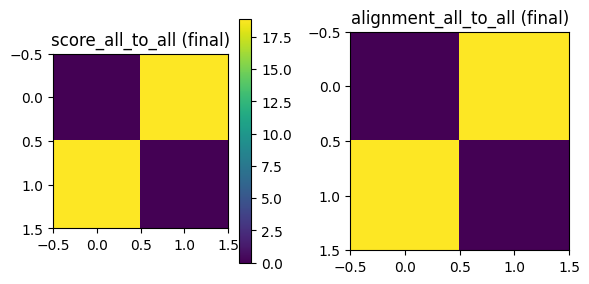

In [48]:
aligner.plot_alignment_results_geometric();

##### 3. Fit non-rigid transformation
Play with parameters until the aligned FOV_images look good. The visualization tool below can help.

We like the following **important parameters**:
- `template`=0.5
- `template_method`='image'


In [49]:
aligner.fit_nonrigid(
    template=0.5,  ## specifies which image to use as the template. Either array (image), integer (ims_moving index), or float (ims_moving fractional index)
    ims_moving=aligner.ims_registered_geo,  ## Input images. Typically the geometrically registered images
    remappingIdx_init=aligner.remappingIdx_geo,  ## The remappingIdx between the original images (and ROIs) and ims_moving
    template_method='image',  ## 'sequential': align images to neighboring images. 'image': align to a single image, good if using geometric registration first
    method='DeepFlow',
    kwargs_method = {
        'DeepFlow': {},  ## Accuracy: Good (good in middle, poor on edges), Speed: Fast (CPU only)
        'RoMa': {  ## Accuracy: Okay (decent in middle, poor on edges), Speed: Slow (can be fast with a GPU), Notes: This method can work on the raw images without pre-registering using geometric methods.
            'model_type': 'outdoor',
        },
        'OpticalFlowFarneback': {  ## Accuracy: Varies (can sometimes be tuned to be the best as there are no edge artifacts), Speed: Medium (CPU only)
            'pyr_scale': 0.7,
            'levels': 5,
            'winsize': 256,
            'iterations': 15,
            'poly_n': 5,
            'poly_sigma': 1.5,            
        },
    },    
)

aligner.transform_images_nonrigid(FOV_images);

Converting float fractional index to integer index: 0.5 -> 1
Finding nonrigid registration warps with mode: DeepFlow, template_method: image


Finding nonrigid registration warps:   0%|          | 0/2 [00:00<?, ?image/s]

Composing nonrigid warp matrices...
Applying nonrigid registration warps to images...


In [ ]:
np.save(r"C:\Users\HAOXUAN YIN\Desktop\code\suite2p data\results", aligner.ims_registered_nonrigid)   # save the image

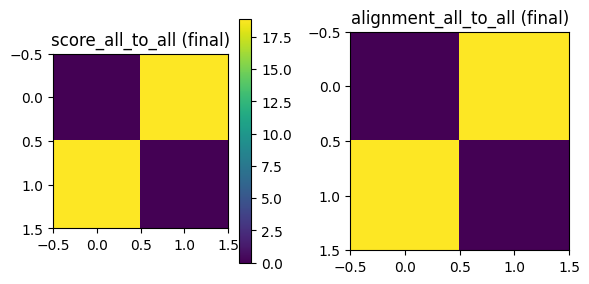

In [11]:
aligner.plot_alignment_results_nonrigid();

##### 4. Transform ROIs

In [12]:
aligner.transform_ROIs(
    ROIs=data.spatialFootprints, 
    remappingIdx=aligner.remappingIdx_nonrigid,
    # remappingIdx=aligner.remappingIdx_geo,
    normalize=True,
);

Registering ROIs...


Registering ROIs:   0%|          | 0/2 [00:00<?, ?it/s]

Ensure that the aligned FOVs look aligned

Pre-alignment below



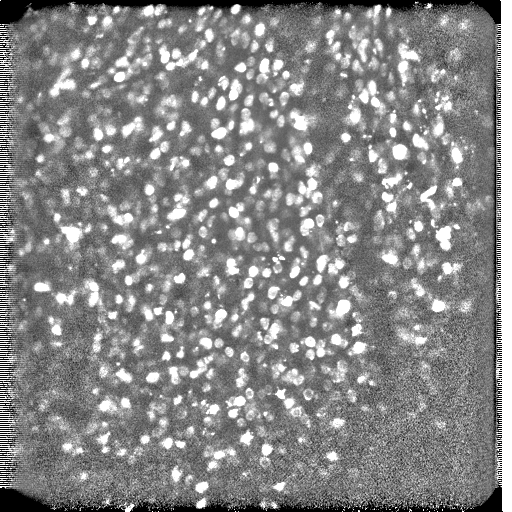

Geometric alignment below



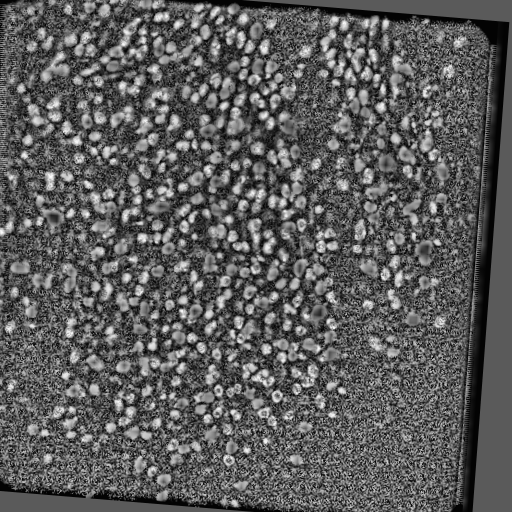

Non-rigid alignment below



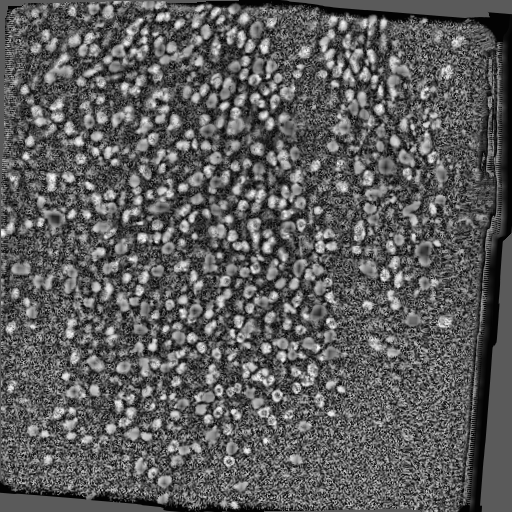

Transformed ROIs below



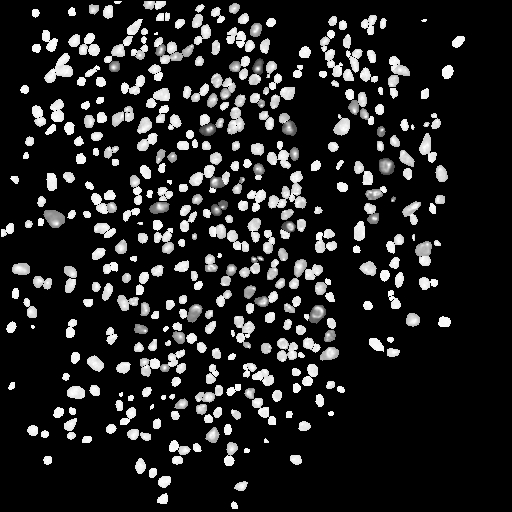

In [13]:
print(f'Pre-alignment below')
roicat.visualization.display_toggle_image_stack(data.FOV_images)
print(f'Geometric alignment below')
roicat.visualization.display_toggle_image_stack(aligner.ims_registered_geo)
print(f'Non-rigid alignment below')
roicat.visualization.display_toggle_image_stack(aligner.ims_registered_nonrigid)
print(f'Transformed ROIs below')
roicat.visualization.display_toggle_image_stack(aligner.get_ROIsAligned_maxIntensityProjection(normalize=True), clim=None)

# Blur ROIs

ROIs from different sessions with zero spatial overlap have very low probability of being considered the same ROI during the clustering step. Blurring the spatial footprint masks can increase the overlap between ROIs that drift apart from each other. It's a good idea to increase the `kernel_halfWidth` if you are working with sparsely labeled ROIs or ROIs that change/move from session to session.

In [14]:
blurrer = roicat.tracking.blurring.ROI_Blurrer(
    frame_shape=(data.FOV_height, data.FOV_width),  ## FOV height and width
    kernel_halfWidth=4,  ## The half width of the 2D gaussian used to blur the ROI masks
    plot_kernel=False,  ## Whether to visualize the 2D gaussian
)

blurrer.blur_ROIs(
    spatialFootprints=aligner.ROIs_aligned[:],
);

Preparing the Toeplitz convolution matrix
Performing convolution for blurring


# ROInet embedding

This step passes the images of each ROI through the ROInet neural network. The inputs are the images, the output is an array describing the visual properties of each ROI.

Initialize the ROInet object. The `ROInet_embedder` class will automatically download and load a pretrained ROInet model. If you have a GPU, this step will be much faster.

In [15]:
dir_temp = tempfile.gettempdir()

roinet = roicat.ROInet.ROInet_embedder(
    device=DEVICE,  ## Which torch device to use ('cpu', 'cuda', etc.)
    dir_networkFiles=dir_temp,  ## Directory to download the pretrained network to
    download_method='check_local_first',  ## Check to see if a model has already been downloaded to the location (will skip if hash matches)
    download_url='https://osf.io/x3fd2/download',  ## URL of the model
    download_hash='7a5fb8ad94b110037785a46b9463ea94',  ## Hash of the model file
    forward_pass_version='latent',  ## How the data is passed through the network
    verbose=True,  ## Whether to print updates
)

File already exists locally: C:\Users\HAOXUAN YIN\AppData\Local\Temp\ROInet.zip
Hash of local file matches provided hash_hex.
Extracting C:\Users\HAOXUAN YIN\AppData\Local\Temp\ROInet.zip to C:\Users\HAOXUAN YIN\AppData\Local\Temp.
Completed zip extraction.
Imported model from C:\Users\HAOXUAN YIN\AppData\Local\Temp\ROInet_tracking_20220527\model.py
Loaded params_model from C:\Users\HAOXUAN YIN\AppData\Local\Temp\ROInet_tracking_20220527\params.json


d:\anaconda\envs\roicat\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda\envs\roicat\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Generated network using params_model
Loaded state_dict into network from C:\Users\HAOXUAN YIN\AppData\Local\Temp\ROInet_tracking_20220527\ConvNext_tiny__1_0_best__simCLR.pth
Loaded network onto device cpu


Resize ROIs and prepare a dataloader.

**Important parameters**:
- `um_per_pixel`: (same as specified in `data` object). Resolution of FOV. This is used to resize the ROIs to be relatively consistent across resolutions.

In [16]:
roinet.generate_dataloader(
    ROI_images=data.ROI_images,  ## Input images of ROIs
    um_per_pixel=data.um_per_pixel,  ## Resolution of FOV
    pref_plot=False,  ## Whether or not to plot the ROI sizes
    
    jit_script_transforms=False,  ## (advanced) Whether or not to use torch.jit.script to speed things up
    
    batchSize_dataloader=8,  ## (advanced) PyTorch dataloader batch_size
    pinMemory_dataloader=True,  ## (advanced) PyTorch dataloader pin_memory
    numWorkers_dataloader=mp.cpu_count(),  ## (advanced) PyTorch dataloader num_workers
    persistentWorkers_dataloader=True,  ## (advanced) PyTorch dataloader persistent_workers
    prefetchFactor_dataloader=2,  ## (advanced) PyTorch dataloader prefetch_factor
);

Starting Image Resizer


d:\anaconda\envs\roicat\Lib\site-packages\roicat\util.py:416: UserWarning: RH WARNING: unable to get gcc version. Got error: [WinError 2] 系统找不到指定的文件。
  warnings.warn(f'RH WARNING: unable to get gcc version. Got error: {e}')


Creating dataloader
Defined image transformations: Sequential(
  (0): ScaleDynamicRange(scaler_bounds=(0, 1))
  (1): Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
  (2): TileChannels(dim=0)
)
Defined dataset
Defined dataloader


Pass the data through the network. Expect for large datasets (~40,000 ROIs) that this takes around 15 minutes on CPU or 1 minute on GPU.

In [17]:
roinet.generate_latents();

starting: running data through network


d:\anaconda\envs\roicat\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  0%|          | 0/120 [00:00<?, ?it/s]

completed: running data through network


# Scattering wavelet embedding

This is similar to the ROInet embedding in purpose.

In [ ]:
swt = roicat.tracking.scatteringWaveletTransformer.SWT(
    kwargs_Scattering2D={'J': 2, 'L': 12},  ## 'J' is the number of convolutional layers. 'L' is the number of wavelet angles.
    image_shape=data.ROI_images[0].shape[1:3],  ## size of a cropped ROI image
    device=DEVICE,  ## PyTorch device
)

swt.transform(
    ROI_images=roinet.ROI_images_rs,  ## All the cropped and resized ROI images
    batch_size=100,  ## Batch size for each iteration (smaller is less memory but slower)
);

SWT initialized
Starting: SWT transform on ROIs


  0%|          | 0/9.53 [00:00<?, ?it/s]

Completed: SWT transform on ROIs


# Compute similarities

Now we can compare the similarities of the ROIs. This includes calculating 4 kinds of similarities:
1. `s_sf`: 'similarity spatial footprint'. The physical overlap between ROIs.
2. `s_NN`: 'similarity neural network'. The similarities of the embeddings out of ROInet.
3. `s_SWT`: 'similarity scaterring wavelet transform'. The similarities of the embeddings out of the scattering wavelet transformer.
4. `s_sesh`: 'similarity sessions'. 0 if from the same session, 1 if from different sessions. ROIs from the same session have 0 probability of being the same.

The result of this step will be a set of pairwise similarity matrices.

Initialize the `ROI_graph` class and compute similarities.
To make computation more efficient, only ROIs within the same 'block' are compared against each other.

d:\anaconda\envs\roicat\Lib\site-packages\roicat\util.py:416: UserWarning: RH WARNING: unable to get gcc version. Got error: [WinError 2] 系统找不到指定的文件。
  warnings.warn(f'RH WARNING: unable to get gcc version. Got error: {e}')


Computing pairwise similarity between ROIs...


  0%|          | 0/16 [00:00<?, ?it/s]

Joining blocks into full similarity matrices...
Joining s_sf...
Joining s_NN...
Joining s_SWT...
Joining s_sesh...


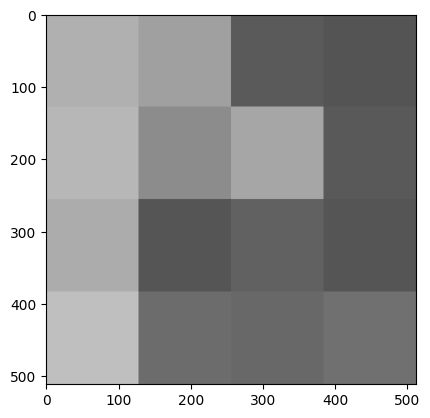

In [19]:
sim = roicat.tracking.similarity_graph.ROI_graph(
    n_workers=-1,  ## Number of CPU cores to use. -1 for all.
    frame_height=data.FOV_height,
    frame_width=data.FOV_width,
    block_height=128,  ## size of a block
    block_width=128,  ## size of a block
    algorithm_nearestNeigbors_spatialFootprints='brute',  ## algorithm used to find the pairwise similarity for s_sf. ('brute' is slow but exact. See docs for others.)
    verbose=True,  ## Whether to print outputs
)

sim.visualize_blocks()

s_sf, s_NN, s_SWT, s_sesh = sim.compute_similarity_blockwise(
    spatialFootprints=blurrer.ROIs_blurred,  ## Mask spatial footprints
    features_NN=roinet.latents,  ## ROInet output latents
    features_SWT=swt.latents,  ## Scattering wavelet transform output latents
    ROI_session_bool=data.session_bool,  ## Boolean array of which ROIs belong to which sessions
    spatialFootprint_maskPower=1.0,  ##  An exponent to raise the spatial footprints to to care more or less about bright pixels
);

It is useful to normalize the similarity matrices using the local ROIs.

In [20]:
sim.make_normalized_similarities(
    centers_of_mass=data.centroids,  ## ROI centroid positions
    features_NN=roinet.latents,  ## ROInet latents
    features_SWT=swt.latents,  ## SWT latents
    k_max=data.n_sessions*100,  ## Maximum number of nearest neighbors to consider for the normalizing distribution
    k_min=data.n_sessions*10,  ## Minimum number of nearest neighbors to consider for the normalizing distribution
    algo_NN='kd_tree',  ## Nearest neighbors algorithm to use
    device=DEVICE,
)

Finding k-range of center of mass distance neighbors for each ROI...
Normalizing Neural Network similarity scores...


  0%|          | 0/953 [00:00<?, ?it/s]

Normalizing SWT similarity scores...


  0%|          | 0/953 [00:00<?, ?it/s]

# Clustering

This step does the following:
1. Mix the similarity matrices into a single distance matrix
2. Prune the distance matrix to remove low probability connections
3. Perform clustering
4. Compute quality metrics

#### 1. Mix the similarity matrices into a single distance matrix

This step can be done either automatically, using the `clusterer.find_optimal_parameters_for_pruning` method, or manually by specifying the `kwargs_makeConjunctiveDistanceMatrix` dictionary. If you have a smaller total number of ROIs (<100 ROIs per session and/or <8 sessions), then it may be a good idea to manually play with the parameters in the next cell instead of using the automatic method.

<br></br>

##### Option A: Automatic Method
This step finds the optimal parameters to mix the similarity matrices by tuning mixing parameters to maximally separate the distributions of pairwise similarities for ROI pairs known to be different and ROI pairs that are likely matched.

Some of the details of underlying algorithm:
1. For each step in the optimization process, all the similarity matrices (`s_sf`, `s_NN_z`, `s_SWT_z`, `s_sesh`) are each passed through a sigmoid activation function that is parameterized (e.g. `'power_SF'`, `'sig_SF_kwargs'`), then all the similarity matrices are combined using a p-norm, where the 'p' is parameterized with `'p_norm'`. This results in a single conjunctive similarity matrix called `sConj` bounded between 0-1. 
2. `sConj` is converted into a distance matrix `dConj` (bounded from 1-0).
3. `dConj` is then passed through the objective function: The full distance matrix is separated into a few components. First, all pairs of ROIs that are known to be from 'different' sources because they are from the same session are separated out into a distribution of pairwise distances (`d_diff`). Second, we define pairs of ROIs that are likely to be from the same source as `d_same` = `d_all` - `d_diff`. The objective function is then the overlap between the `d_diff` and `d_same` distributions. 
4. The objective function is minimized by tuning the mixing parameters in `kwargs_makeConjunctiveDistanceMatrix`.
5. The output of this step is the optimal `kwargs_makeConjunctiveDistanceMatrix` dictionary.

<br></br>

##### Option B: Manual Method
You can also simply specify the `kwargs_makeConjunctiveDistanceMatrix` dictionary manually. This is useful if you have a good idea of what the optimal parameters are or if the automatic method is not working well. Uncomment the code block below to overwrite the `kwargs_mcdm_tmp` variable.

<br></br>

#### TROUBLESHOOTING FOR THIS STEP
- If you have any issues, just email Rich Hakim or open an issue on the github issues page.
- If you see: `'No crossover found, not plotting'`: Your data may not be easily separable. For some people, this is because the number of matching ROIs is very low compared to the number of non-matching ROIs. I recommend trying out the manual method.

In [21]:
## Initialize the clusterer object by passing the similarity matrices in
clusterer = roicat.tracking.clustering.Clusterer(
    s_sf=sim.s_sf,
    s_NN_z=sim.s_NN_z,
    s_SWT_z=sim.s_SWT_z,
    s_sesh=sim.s_sesh,
    verbose=1,
)

d:\anaconda\envs\roicat\Lib\site-packages\roicat\util.py:416: UserWarning: RH WARNING: unable to get gcc version. Got error: [WinError 2] 系统找不到指定的文件。
  warnings.warn(f'RH WARNING: unable to get gcc version. Got error: {e}')


#### Automatic method

In [22]:
# Uncomment below to automatically find mixing parameters
kwargs_makeConjunctiveDistanceMatrix_best = clusterer.find_optimal_parameters_for_pruning(
    n_bins=None,  ## Number of bins to use for the histograms of the distributions. If None, then a heuristic is used.
    smoothing_window_bins=None,  ## Number of bins to use to smooth the distributions. If None, then a heuristic is used.
    kwargs_findParameters={
        'n_patience': 300,  ## Number of optimization epoch to wait for tol_frac to converge
        'tol_frac': 0.001,  ## Fractional change below which optimization will conclude
        'max_trials': 1200,  ## Max number of optimization epochs
        'max_duration': 60*10,  ## Max amount of time (in seconds) to allow optimization to proceed for
        'value_stop': 0.0,  ## Goal value. If value equals or goes below value_stop, optimization is stopped.
    },
    bounds_findParameters={
        'power_NN': [0.0, 2.],  ## Bounds for the exponent applied to s_NN
        'power_SWT': [0.0, 2.],  ## Bounds for the exponent applied to s_SWT
        'p_norm': [-5, -0.1],  ## Bounds for the p-norm p value (Minkowski) applied to mix the matrices
        'sig_NN_kwargs_mu': [0., 1.0],  ## Bounds for the sigmoid center for s_NN
        'sig_NN_kwargs_b': [0.1, 1.5],  ## Bounds for the sigmoid slope for s_NN
        'sig_SWT_kwargs_mu': [0., 1.0],  ## Bounds for the sigmoid center for s_SWT
        'sig_SWT_kwargs_b': [0.1, 1.5],  ## Bounds for the sigmoid slope for s_SWT
    },
    n_jobs_findParameters=-1,  ## Number of CPU cores to use (-1 is all cores)
    seed=SEED,  ## Random seed
)

Finding mixing parameters using automated hyperparameter tuning...


  0%|          | 0/1200 [00:00<?, ?it/s]

Completed automatic parameter search. Best value found: 351.169921875 with parameters {'power_NN': 0.3386298364770472, 'power_SWT': 0.20944485016762898, 'p_norm': -2.9203083814164694, 'sig_NN_kwargs': {'mu': 0.48820466343613383, 'b': 0.23425073037112842}, 'sig_SWT_kwargs': {'mu': 0.2928527454213644, 'b': 0.13819471096208405}}


#### View mixing results
The goal is to see a **bimodal curve** in the pairwise similarities and a **clear cross-over point** (specified by the vertical dotted line) between 'same' and 'diff' pairs of ROIs.

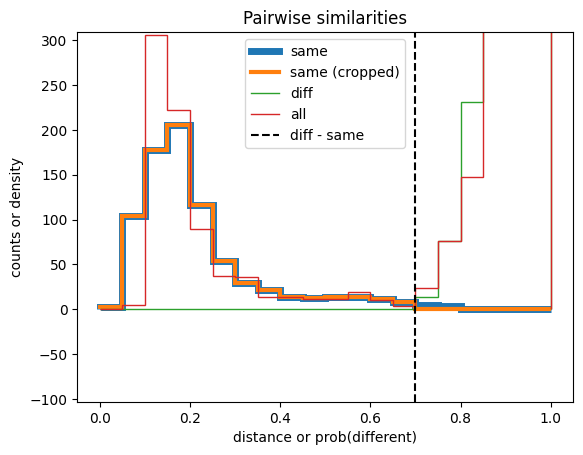

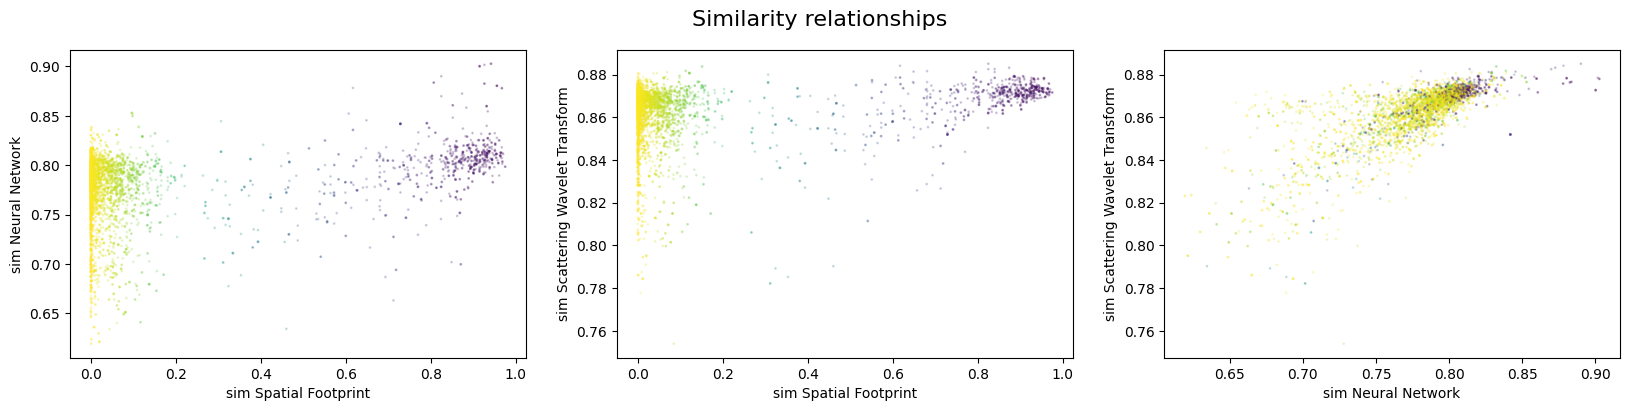

In [23]:
clusterer.plot_distSame(kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best)

clusterer.plot_similarity_relationships(
    plots_to_show=[1,2,3], 
    max_samples=100000,  ## Make smaller if it is running too slow
    kwargs_scatter={'s':1, 'alpha':0.2},
    kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best
);

##### 2. Prune the distance matrix

We can remove all connections in the distance graph with probabilities of connection of less than 50%. We estimate this cutoff distance as the cross-over point between the 'same' and 'different' distributions.

**Important parameter**\
`stringency`: This value changes the threshold for pruning the distance matrix. A higher value will result in less pruning, and a lower value will result in more pruning. The value will be multiplied by the inferred threshold to get the new one.


In [24]:
clusterer.make_pruned_similarity_graphs(
    d_cutoff=None,  ## Optionally manually specify a distance cutoff
    kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best,
    stringency=1.0,  ## Modifies the threshold for pruning the distance matrix. Higher values result in LESS pruning. New d_cutoff = stringency * truncated d_cutoff.
    convert_to_probability=False,    
)

Pruning similarity graphs with d_cutoff = 0.699999988079071...


d:\anaconda\envs\roicat\Lib\site-packages\scipy\sparse\_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


##### 3. Cluster

There are two methods for clustering: The standard method `.fit` which is based on HDBSCAN, and `.fit_sequentialHungarian` which is an algorithm that is also used by CaImAn based on the Hungarian algorithm. The standard method takes 1-20 minutes and works better when there are many sessions, the Hungarian method takes seconds and works better when there are fewer sessions (<8).

**Important parameters**:
- For standard **`.fit`** method:
1. `min_cluster_size`: If you only want ROIs clusters with at least a certain number of samples, specify here.
2. `n_iter_violationCorrection`: This parameter controls how fast this step takes. Turning it down has mild effects on quality. We use around ***6***.

- For **`.fit_sequentialHungarian`** method:
1. `thresh_cost`: Determines the threshold of how distant two ROIs can be and still be matched. Smaller value is more stringent.


In [25]:
if data.n_sessions >= 6:
    labels = clusterer.fit(
        d_conj=clusterer.dConj_pruned,  ## Input distance matrix
        session_bool=data.session_bool,  ## Boolean array of which ROIs belong to which sessions
        min_cluster_size=2,  ## Minimum number of ROIs that can be considered a 'cluster'
        n_iter_violationCorrection=6,  ## Number of times to redo clustering sweep after removing violations
        split_intraSession_clusters=True,  ## Whether or not to split clusters with ROIs from the same session
        cluster_selection_method='leaf',  ## (advanced) Method of cluster selection for HDBSCAN (see hdbscan documentation)
        d_clusterMerge=None,  ## Distance below which all ROIs are merged into a cluster
        alpha=0.999,  ## (advanced) Scalar applied to distance matrix in HDBSCAN (see hdbscan documentation)
        discard_failed_pruning=True,  ## (advanced) Whether or not to set all ROIs that could be separated from clusters with ROIs from the same sessions to label=-1
        n_steps_clusterSplit=100,  ## (advanced) How finely to step through distances to remove violations
    )

else:
    labels = clusterer.fit_sequentialHungarian(
        d_conj=clusterer.dConj_pruned,  ## Input distance matrix
        session_bool=data.session_bool,  ## Boolean array of which ROIs belong to which sessions
        thresh_cost=0.8,  ## Threshold. Higher values result in more permissive clustering. Specifically, the pairwise metric distance between ROIs above which two ROIs cannot be clustered together.
    )

Clustering with CaImAn's sequential Hungarian algorithm method...


  0%|          | 0/1 [00:00<?, ?it/s]

##### 4. Quality metrics

Compute various quality scores for each cluster and each ROI.

In [26]:
## SKIP THIS STEP FOR VERY LARGE DATASETS
quality_metrics = clusterer.compute_quality_metrics();

## Collect results

1. Make different versions of the labels for convenience.
2. Put all the useful results and info into a dictionary to save later. ADJUST THIS ANY WAY YOU WANT.
3. Put all the class objects from the run into a dictionary to save later

In [28]:
labels_squeezed, labels_bySession, labels_bool, labels_bool_bySession, labels_dict = roicat.tracking.clustering.make_label_variants(labels=labels, n_roi_bySession=data.n_roi)

results_clusters = {
    'labels': labels_squeezed,
    'labels_bySession': labels_bySession,
    'labels_dict': labels_dict,
    'quality_metrics': clusterer.quality_metrics if hasattr(clusterer, 'quality_metrics') else None,
}

results_all = {
    "clusters":{
        "labels": roicat.util.JSON_List(labels_squeezed),
        "labels_bySession": roicat.util.JSON_List(labels_bySession),
        "labels_bool": labels_bool,
        "labels_bool_bySession": labels_bool_bySession,
        "labels_dict": roicat.util.JSON_Dict(labels_dict),
        "quality_metrics": roicat.util.JSON_Dict(clusterer.quality_metrics) if hasattr(clusterer, 'quality_metrics') else None,
    },
    "ROIs": {
        "ROIs_aligned": aligner.ROIs_aligned,
        "ROIs_raw": data.spatialFootprints,
        "frame_height": data.FOV_height,
        "frame_width": data.FOV_width,
        "idx_roi_session": np.where(data.session_bool)[1],
        "n_sessions": data.n_sessions,
    },
    "input_data": {
        "paths_stat": data.paths_stat,
        "paths_ops": data.paths_ops,
    },
}

run_data = {
    'data': data.__dict__,
    'aligner': aligner.__dict__,
    'blurrer': blurrer.__dict__,
    'roinet': roinet.__dict__,
    'swt': swt.__dict__,
    'sim': sim.__dict__,
    'clusterer': clusterer.__dict__,
}

params_used = {name: mod['params'] for name, mod in run_data.items()}

# Visualize results

In [33]:
print(f'Number of clusters: {len(np.unique(results_clusters["labels"]))}')
print(f'Number of discarded ROIs: {(np.array(results_clusters["labels"])==-1).sum()}')

Number of clusters: 364
Number of discarded ROIs: 227


Look at some of the distributions of the quality metrics.
- Silhouette score is a particularly useful one for this type of clustering. Learn more here: https://en.wikipedia.org/wiki/Silhouette_(clustering)
- We also define a handy 'confidence' variable which is a nice heuristic you can use for thresholding for inclusion criteria
- Note that the `sample_silhouette` score is a per-sample (per-ROI) score. So it can actually be used to remove / subselect ROIs from clusters.

A good rule of thumb is to use an inclusion criteria of:
- `sample_silhouette` > 0.1
- `cluster_silhouette` > 0.2

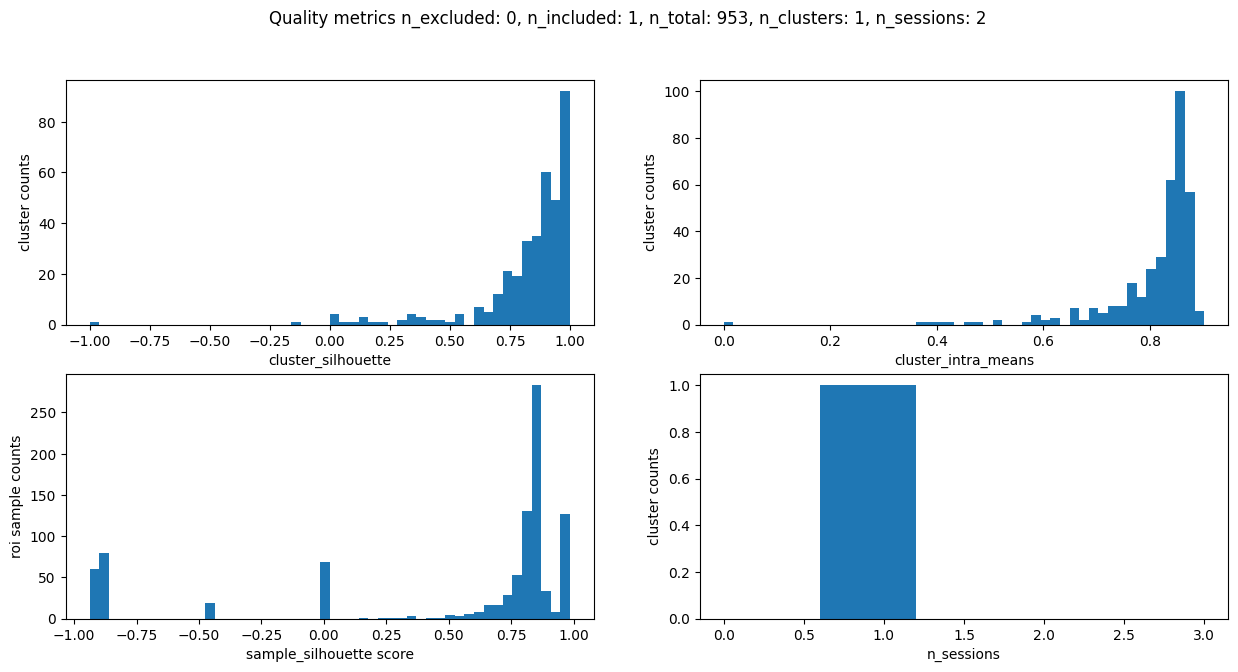

In [30]:
roicat.tracking.clustering.plot_quality_metrics(quality_metrics=quality_metrics, labels=labels_squeezed, n_sessions=data.n_sessions);

Look at a color visualization of the results. ROIs of the same color are considered a part of the same cluster. The colors are assigned randomly.

In [ ]:
use_classificationResults = False
results = roicat.util.RichFile_ROICaT(path=r"C:\Users\HAOXUAN YIN\Desktop\code\suite2p data\results\result.tracking.results_all.richfile").load()
if use_classificationResults:
    results_classification = roicat.util.RichFile_ROICaT(path='/media/rich/bigSSD/data_tmp/test_data/mouse_1.classification_drawn.run_data.richfile').load()
else:
    results_classification = None

FOVs_colored = roicat.visualization.compute_colored_FOV(
    labels=np.array(results['clusters']['labels']),
    spatialFootprints=results['ROIs']['ROIs_aligned'], 
    FOV_height=results['ROIs']['frame_height'], 
    FOV_width=results['ROIs']['frame_width'], 
    alphas_sf=np.array(results['clusters']['quality_metrics']['sample_silhouette']) > 0.8,  ## SET INCLUSION CRITERIA FOR CLUSTERS/LABELS
    alphas_labels=np.array(results['clusters']['quality_metrics']['cluster_silhouette']) > 0.8,  ## SET INCLUSION CRITERIA FOR ROI SAMPLES
)


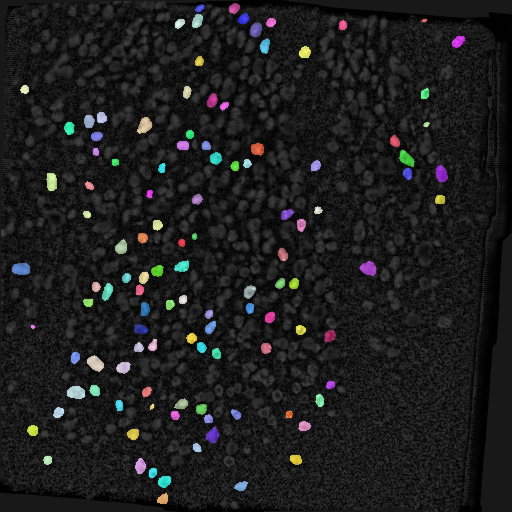


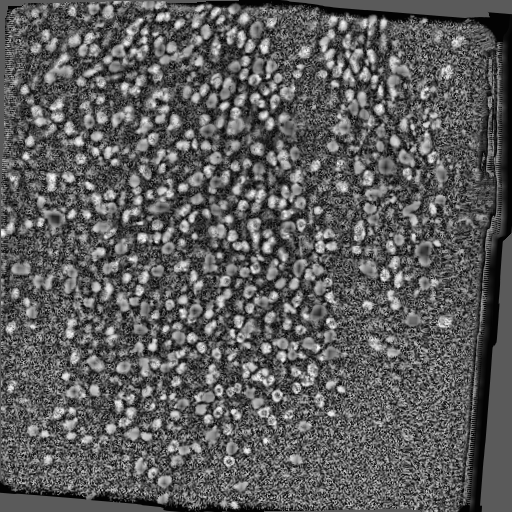

In [39]:
def to_rgb(img):
    """Convert grayscale (H, W) image to RGB (H, W, 3)"""
    if img.ndim == 2:
        return np.stack([img]*3, axis=-1)
    return img

def overlay_images(base_gray, overlay_rgb, alpha=0.6):
    """
    Overlay RGB mask on top of grayscale image.
    base_gray: (H, W), grayscale image
    overlay_rgb: (H, W, 3), color image
    alpha: blending factor for overlay
    """
    base_rgb = to_rgb(base_gray).astype(np.float32)
    overlay_rgb = overlay_rgb.astype(np.float32)
    
    # Normalize both to [0, 1] if not already
    if base_rgb.max() > 1.0:
        base_rgb /= 255.0
    if overlay_rgb.max() > 1.0:
        overlay_rgb /= 255.0

    blended = (1 - alpha) * base_rgb + alpha * overlay_rgb
    return np.clip(blended, 0, 1)  # Keep in float range [0, 1] for display

combined_images = [
    overlay_images(roicat_img, fov_img, alpha=0.6)
    for roicat_img, fov_img in zip(aligner.ims_registered_nonrigid, FOVs_colored)
    # aligner.ims_registered_nonrigid - non-grid aligned image; data.FOV_images - pre-aligned image; aligner.ims_registered_geo - geometric aligned data
]

roicat.visualization.display_toggle_image_stack(combined_images)
roicat.visualization.display_toggle_image_stack(aligner.ims_registered_nonrigid)

# Save results

In [36]:
## Define the directory to save the results to
dir_save = r"C:\Users\HAOXUAN YIN\Desktop\code\suite2p data\results"

name_save = 'result'

paths_save = {
    'results_clusters': str(Path(dir_save) / f'{name_save}.tracking.results_clusters.json'),
    'params_used':      str(Path(dir_save) / f'{name_save}.tracking.params_used.json'),
    'results_all':      str(Path(dir_save) / f'{name_save}.tracking.results_all.richfile'),
    'run_data':         str(Path(dir_save) / f'{name_save}.tracking.run_data.richfile'),
}

In [ ]:
Path(dir_save).mkdir(parents=True, exist_ok=True)
roicat.helpers.json_save(obj=results_clusters, filepath=paths_save['results_clusters'])
roicat.helpers.json_save(obj=params_used, filepath=paths_save['params_used'])
roicat.util.RichFile_ROICaT(path=paths_save['results_all']).save(obj=results_all, overwrite=True)
# roicat.util.RichFile_ROICaT(path=paths_save['run_data']).save(obj=run_data, overwrite=True)

FileNotFoundError: [WinError 3] 系统找不到指定的路径。: 'C:\\Users\\HAOXUAN YIN\\Desktop\\code\\suite2p data\\results\\result.tracking.run_data.richfile.tmp\\aligner.dict_item\\value.dict\\params.dict_item\\value.dict\\fit_geometric.dict_item\\value.dict\\kwargs_method.dict_item\\value.dict\\RoMa.dict_item\\value.dict\\model_type.dict_item'

Optionally save the FOV_clusters images as a GIF

In [ ]:
roicat.helpers.save_gif(
    array=roicat.helpers.add_text_to_images(
        images=[(f * 255).astype(np.uint8) for f in FOV_clusters], 
        text=[[f"{ii}",] for ii in range(len(FOV_clusters))], 
        font_size=3,
        line_width=10,
        position=(30, 90),
    ), 
    path=str(Path(dir_save).resolve() / 'visualization' / 'FOV_clusters_highQuality.gif'),
    frameRate=10.0,
    loop=0,
)

# Extras

##### Demo: Importing richfiles

Simple output files are saved as .json files, which are easily handled. However, complex output files are saved using a custom format called `richfile`, which are basically just structured directories containing data files. This is a demonstration of how to import and handle richfile directories.

In [ ]:
## Make a richfile object of the results_all dictionary
r = roicat.util.RichFile_ROICaT(r"C:\Users\HAOXUAN YIN\Desktop\code\result.tracking.results_all.richfile")
## You can load it
temp_results_all = r.load()
## You can load part of it by indexing into the richfile object
print(f"n_sessions: {r['ROIs']['n_sessions'].load()}")
print('')
## You can view the tree structure
r.view_tree()

n_sessions: 8

Path: C:\Users\HAOXUAN YIN\Desktop\code\result.tracking.results_all.richfile (dict)
├── 'clusters':   (dict)
|    ├── 'labels':   (json_list)
|    ├── 'labels_bySession':   (json_list)
|    ├── 'labels_bool':   (scipy_sparse_array)
|    ├── 'labels_bool_bySession':   (list)
|    |    ├──   (scipy_sparse_array)
|    |    ├──   (scipy_sparse_array)
|    |    ├──   (scipy_sparse_array)
|    |    ├──   (scipy_sparse_array)
|    |    ├──   (scipy_sparse_array)
|    |    ├──   (scipy_sparse_array)
|    |    ├──   (scipy_sparse_array)
|    |    ├──   (scipy_sparse_array)
|    |    
|    ├── 'labels_dict':   (json_dict)
|    ├── 'quality_metrics':   (json_dict)
|    
├── 'ROIs':   (dict)
|    ├── 'ROIs_aligned':   (list)
|    |    ├──   (scipy_sparse_array)
|    |    ├──   (scipy_sparse_array)
|    |    ├──   (scipy_sparse_array)
|    |    ├──   (scipy_sparse_array)
|    |    ├──   (scipy_sparse_array)
|    |    ├──   (scipy_sparse_array)
|    |    ├──   (scipy_sparse_array)
|  

#### Look at `params_used`
These were the parameters that were used in the run, they can be used to reproduce the run using the CLI by creating a params.yaml file.


In [ ]:
params_used

NameError: name 'params_used' is not defined

##### Legacy saving methods

In [ ]:
dir_save = Path('/media/rich/bigSSD/data_tmp/test_data/').resolve()
name_save = Path(dir_allOuterFolders).resolve().name

path_save = dir_save / (name_save + '.ROICaT.tracking.results' + '.pkl')
print(f'path_save: {path_save}')

In [ ]:
run_data_sd = {
    'data': data.serializable_dict,
    'aligner': aligner.serializable_dict,
    'blurrer': blurrer.serializable_dict,
    'roinet': roinet.serializable_dict,
    'swt': swt.serializable_dict,
    'sim': sim.serializable_dict,
    'clusterer': clusterer.serializable_dict,
}

In [ ]:
roicat.helpers.pickle_save(
    obj=results_all,
    filepath=path_save,
    mkdir=True,
)

roicat.helpers.pickle_save(
    obj=run_data_sd,
    filepath=str(dir_save / (name_save + '.ROICaT.tracking.rundata' + '.pkl')),
    mkdir=True,
)


Optionally save results as a matlab file.

In [ ]:
roicat.helpers.matlab_save(
    obj=results_all,
    filepath=str(dir_save / (name_save + '.ROICaT.tracking.results' + '.mat')),
)

## Save more figures

In [ ]:
### Save gifs of the FOVs at different stages of alignment
roicat.helpers.save_gif(
    array=roicat.helpers.add_text_to_images(
        images=[((f / np.max(f)) * 255).astype(np.uint8) for f in FOV_images], 
        text=[[f"{ii}",] for ii in range(len(FOV_clusters))], 
        font_size=3,
        line_width=10,
        position=(30, 90),
    ), 
    path=str(Path(dir_save).resolve() / 'visualization' / 'FOV_images.gif'),
    frameRate=10,
    loop=0,
)

roicat.helpers.save_gif(
    array=roicat.helpers.add_text_to_images(
        images=[((f / np.max(f)) * 255).astype(np.uint8) for f in aligner.ims_registered_geo], 
        text=[[f"{ii}",] for ii in range(len(FOV_clusters))], 
        font_size=3,
        line_width=10,
        position=(30, 90),
    ), 
    path=str(Path(dir_save).resolve() / 'visualization' / 'FOV_images_aligned_geometric.gif'),
    frameRate=10,
    loop=0,
)

roicat.helpers.save_gif(
    array=roicat.helpers.add_text_to_images(
        images=[((f / np.max(f)) * 255).astype(np.uint8) for f in aligner.ims_registered_nonrigid], 
        text=[[f"{ii}",] for ii in range(len(FOV_clusters))], 
        font_size=3,
        line_width=10,
        position=(30, 90),
    ), 
    path=str(Path(dir_save).resolve() / 'visualization' / 'FOV_images_aligned_nonrigid.gif'),
    frameRate=10,
    loop=0,
)

roicat.helpers.save_gif(
    array=roicat.helpers.add_text_to_images(
        images=[((f / np.max(f)) * 255).astype(np.uint8) for f in aligner.get_ROIsAligned_maxIntensityProjection(normalize=True)], 
        text=[[f"{ii}",] for ii in range(len(FOV_clusters))], 
        font_size=3,
        line_width=10,
        position=(30, 90),
    ), 
    path=str(Path(dir_save).resolve() / 'visualization' / 'FOV_ROIs_aligned.gif'),
    frameRate=10,
    loop=0,
)